In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import os 
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

dirs = ['../DataGeneration/Python', './net/']
for d in dirs:
    if d not in sys.path:
        sys.path.append(d)

import Sample
import Dataloader

from Transformer import Transformer

In [2]:
DATASET_PATH = '../Dataset/CC10k.npy'
N_WORKERS = 0

# From data
d_input = 4 # 10 Ages + 4 thermochronometers*(10 samples))
d_output = 7+3*5+5  # Output sequence 7 constants + 3 exhumation_history params * 5 rates + 5 uplift rates
seqlen=10

# Hyperparameters
BATCH_SIZE = 5
D_MODEL = 64
q = 8 
v = 8
h = 8
Ne = 4
Nd = 4
DROPOUT = 0.3

LR = .003

In [3]:
geoData = Dataloader.formattedLoader(d_input, d_output, DATASET_PATH) # Get input data formatted for network
data_train, data_val, data_test = random_split(geoData, (9000, 500, 500))

dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

In [4]:
model_path = 'Checkpoints/model_2023_03_05__215511.pth'

state_dict = torch.load(model_path)
optimizePrime = Transformer(d_input, seqlen, d_output, D_MODEL, q, v, h, Ne, Nd, BATCH_SIZE, DROPOUT) 
optimizePrime.load_state_dict(state_dict)
optimizer = torch.optim.Adam(optimizePrime.parameters(), lr=LR)
loss_function = nn.MSELoss()

In [9]:
optimizePrime = Transformer(d_input, seqlen, d_output, D_MODEL, q, v, h, Ne, Nd, BATCH_SIZE, DROPOUT) 
optimizer = torch.optim.Adam(optimizePrime.parameters(), lr=LR)
loss_function = nn.MSELoss()

In [23]:
epoch_loss[-1]

4.424787678824531

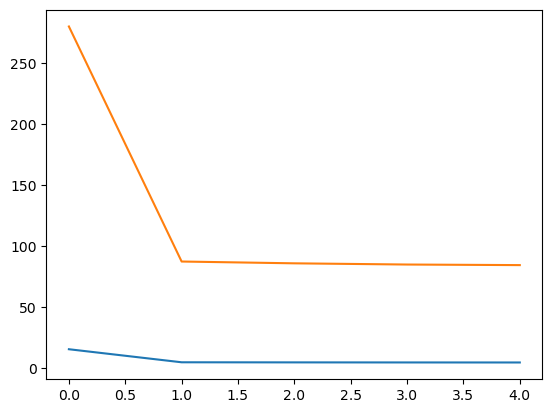

In [22]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.plot(range(len(epoch_val_loss)), epoch_val_loss)

In [11]:
def plot_loss(epoch_loss, epoch_val_loss, EPOCHS):
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_xlim(1, EPOCHS)
    ax.set_ylabel('Loss')
    ax.set_ylim(0,1)

    plt.plot(range(len(epoch_loss)), epoch_loss)
    plt.plot(range(len(epoch_val_loss)), epoch_val_loss)

In [24]:
model_save_path = f'Checkpoints/model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
epoch_loss_best = np.inf # TODO: REMOVE IF INITIALIZING

batch_loss = []
epoch_loss = []
epoch_val_loss = []
EPOCHS = 5

for epoch in range(EPOCHS):
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {epoch+1:3d}/{EPOCHS}]") as pbar:
        
        # Training phase
        optimizePrime.train()
        running_loss = 0

        for i, (x, y) in enumerate(dataloader_train):
            
            # Forward pass
            optimizer.zero_grad()
            x = x.float()
            yhat = optimizePrime(x)
            loss = loss_function(y.float(), yhat)

            # Back pass
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item()/BATCH_SIZE)
            running_loss+= loss.item()
            pbar.set_postfix({'total loss': running_loss})
            pbar.update(x.shape[0])

        epoch_loss.append(running_loss/len(dataloader_train.dataset))

        # Validation phase
        optimizePrime.eval()
        running_loss = 0

        with torch.no_grad():
            for i, (x, y) in enumerate(dataloader_val):
                
                # Forward pass
                optimizer.zero_grad()
                x = x.float()
                yhat = optimizePrime(x)
                loss = loss_function(y.float(), yhat)

                running_loss+= loss.item()

            # Loss per sample
            epoch_val_loss.append(running_loss/len(dataloader_val.dataset))

    if epoch_loss[-1] < epoch_loss_best and False:
        epoch_loss_best = running_loss
        torch.save(optimizePrime.state_dict(), model_save_path)    


[Epoch   5/5]: 100%|██████████| 9000/9000 [01:01<00:00, 146.24it/s, total loss=3.92e+4]


<Figure size 640x480 with 0 Axes>

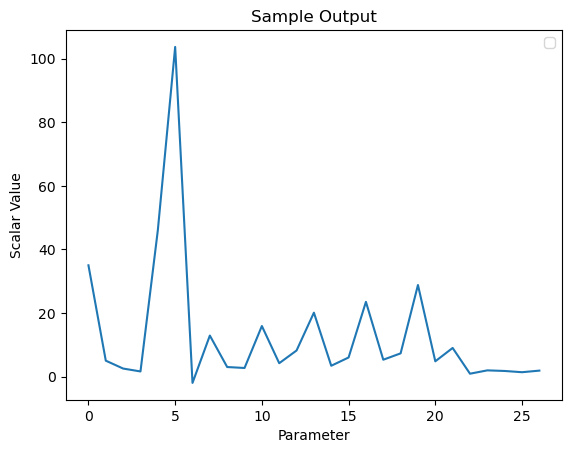

In [18]:
for i, (x, y) in enumerate(dataloader_train):        
    # Zero gradients
    x = x.float()
    y = y
    if i == 20:
        break
    X = optimizePrime(x)[1]
    X = X.detach().numpy()
    plt.figure(i)
    #plt.plot(range(len(X)), X)
    fig, ax = plt.subplots()
    ax.set_xlabel("Parameter")
    ax.set_ylabel("Scalar Value")
    plt.title("Sample Output")
    plt.legend(['Input'])
    plt.plot(range(len(y[1])), y[1])

    break


In [83]:
epoch_loss_best

36844.99926567078

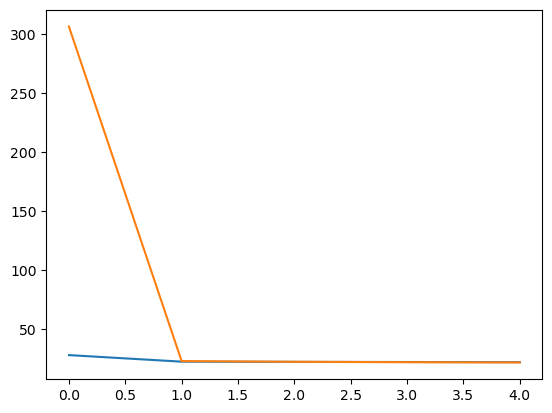

In [8]:
plt.plot(range(len(epoch_loss)), np.array(epoch_loss)/len(dataloader_train))
plt.plot(range(len(epoch_val_loss)), np.array(epoch_val_loss)/len(dataloader_val))

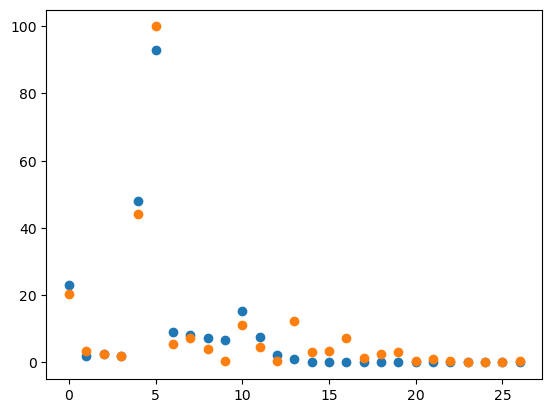

In [9]:
X = (optimizePrime(x)[0])
X = X.detach().numpy()
plt.scatter(range(len(y[0])), y[0])
plt.scatter(range(len(X)), X)

In [10]:
torch.save(optimizePrime.state_dict(), 'Checkpoints/TST.pth')    

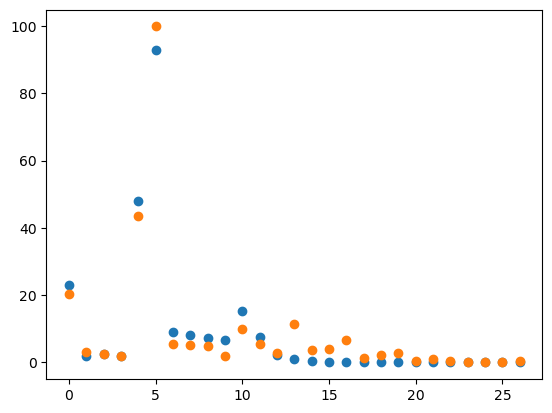

In [11]:
X = (optimizePrime(x)[0])
X = X.detach().numpy()
plt.scatter(range(len(y[0])), y[0])
plt.scatter(range(len(X)), X)